# Setup and Imports

In [16]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot style
plt.style.use("ggplot")
sns.set(font_scale=1.1)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
# For consistent randomness if needed
np.random.seed(42)

# Load Datasets

In [2]:
# Load internal data
internal_df_flows = pd.read_csv("../data/daily_flow_table.csv", parse_dates=["date"])

# Load perturbed Morningstar data
morningstar_df_flows = pd.read_csv("../data/morningstar_flow_table_perturbed.csv", parse_dates=["date"])

# Load perturbed Bloomberg data
bloomberg_df_flows = pd.read_csv("../data/bloomberg_flow_table_perturbed.csv", parse_dates=["date"])

# Preview
internal_df_flows.head(2), morningstar_df_flows.head(2), bloomberg_df_flows.head(2)

(  ticker_id    asset_name asset_type   provider       date        inflow       outflow      net_flow     nav
 0       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-01  2.093163e+08  1.711885e+08  3.812775e+07  162.21
 1       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-02  1.660922e+07  2.476862e+08 -2.310770e+08  162.10,
   ticker_id    asset_name asset_type   provider       date        inflow       outflow      net_flow     nav
 0       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-01  2.164655e+08  1.716837e+08  4.478182e+07  162.21
 1       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-02  1.810183e+07  2.489855e+08 -2.308836e+08  162.10,
   ticker_id    asset_name asset_type   provider       date        inflow       outflow      net_flow     nav
 0       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-01  2.114814e+08  1.739297e+08  3.755168e+07  162.21
 1       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-02  1.947456e+07  2.500563e+08 -2.305818e+08  162.10)

# Clean and Rename Columns

In [3]:
# Columns to keep
cols = ["ticker_id", "provider", "date", "inflow", "outflow", "net_flow"]

# Clean & rename internal
internal_df_flows = internal_df_flows[cols].rename(columns={
    "inflow": "inflow_internal",
    "outflow": "outflow_internal",
    "net_flow": "net_flow_internal"
})

# Clean & rename Morningstar
morningstar_df_flows = morningstar_df_flows[cols].rename(columns={
    "inflow": "inflow_mstar",
    "outflow": "outflow_mstar",
    "net_flow": "net_flow_mstar"
})

# Clean & rename Bloomberg
bloomberg_df_flows = bloomberg_df_flows[cols].rename(columns={
    "inflow": "inflow_bbg",
    "outflow": "outflow_bbg",
    "net_flow": "net_flow_bbg"
})

# Preview internal
internal_df_flows.head()

,ticker_id,provider,date,inflow_internal,outflow_internal,net_flow_internal
0,SPY,BlackRock,2024-01-01,2.093163e+08,1.711885e+08,3.812775e+07
1,SPY,BlackRock,2024-01-02,1.660922e+07,2.476862e+08,-2.310770e+08
2,SPY,BlackRock,2024-01-03,1.718910e+08,2.024759e+08,-3.058490e+07
3,SPY,BlackRock,2024-01-04,5.199350e+07,5.244518e+07,-4.516759e+05
4,SPY,BlackRock,2024-01-05,8.699916e+07,1.500560e+08,-6.305682e+07


# Merge All Three Datasets

In [4]:
# Merge internal and Morningstar first
merged_df = pd.merge(
    internal_df_flows,
    morningstar_df_flows,
    on=["ticker_id", "provider", "date"],
    how="inner"
)

# Merge in Bloomberg data
merged_df = pd.merge(
    merged_df,
    bloomberg_df_flows,
    on=["ticker_id", "provider", "date"],
    how="inner"
)

# Preview merged data
merged_df.head()

,ticker_id,provider,date,inflow_internal,outflow_internal,net_flow_internal,inflow_mstar,outflow_mstar,net_flow_mstar,inflow_bbg,outflow_bbg,net_flow_bbg
0,SPY,BlackRock,2024-01-01,2.093163e+08,1.711885e+08,3.812775e+07,2.164655e+08,1.716837e+08,4.478182e+07,2.114814e+08,1.739297e+08,3.755168e+07
1,SPY,BlackRock,2024-01-02,1.660922e+07,2.476862e+08,-2.310770e+08,1.810183e+07,2.489855e+08,-2.308836e+08,1.947456e+07,2.500563e+08,-2.305818e+08
2,SPY,BlackRock,2024-01-03,1.718910e+08,2.024759e+08,-3.058490e+07,1.735013e+08,2.039746e+08,-3.047328e+07,1.724224e+08,2.026410e+08,-3.021860e+07
3,SPY,BlackRock,2024-01-04,5.199350e+07,5.244518e+07,-4.516759e+05,5.293818e+07,5.358740e+07,-6.492210e+05,5.349211e+07,5.365269e+07,-1.605745e+05
4,SPY,BlackRock,2024-01-05,8.699916e+07,1.500560e+08,-6.305682e+07,9.462874e+07,1.516885e+08,-5.705972e+07,8.821870e+07,1.556575e+08,-6.743878e+07


# Compute Discrepancies

In [5]:
for source in ["mstar", "bbg"]:
    for metric in ["inflow", "outflow", "net_flow"]:
        col_internal = f"{metric}_internal"
        col_source = f"{metric}_{source}"
        
        # Absolute difference
        merged_df[f"{metric}_abs_diff_{source}"] = (merged_df[col_internal] - merged_df[col_source]).abs().round(2)
        
        # Relative difference (avoid divide-by-zero)
        merged_df[f"{metric}_rel_diff_{source}"] = np.where(
            merged_df[col_internal] != 0,
            (merged_df[col_internal] - merged_df[col_source]).abs() / merged_df[col_internal],
            np.nan
        ).round(4)

# Preview
merged_df.filter(like="diff").head()

,inflow_abs_diff_mstar,inflow_rel_diff_mstar,outflow_abs_diff_mstar,outflow_rel_diff_mstar,net_flow_abs_diff_mstar,net_flow_rel_diff_mstar,inflow_abs_diff_bbg,inflow_rel_diff_bbg,outflow_abs_diff_bbg,outflow_rel_diff_bbg,net_flow_abs_diff_bbg,net_flow_rel_diff_bbg
0,7149213.04,0.0342,495145.07,0.0029,6654067.97,0.1745,2165120.80,0.0103,2741188.04,0.0160,576067.24,0.0151
1,1492609.43,0.0899,1299285.14,0.0052,193324.29,-0.0008,2865347.26,0.1725,2370147.20,0.0096,495200.06,-0.0021
2,1610341.92,0.0094,1498723.25,0.0074,111618.67,-0.0036,531410.90,0.0031,165115.98,0.0008,366294.92,-0.0120
3,944678.57,0.0182,1142223.68,0.0218,197545.11,-0.4374,1498612.27,0.0288,1207510.89,0.0230,291101.38,-0.6445
4,7629583.10,0.0877,1632479.93,0.0109,5997103.17,-0.0951,1219546.70,0.0140,5601504.10,0.0373,4381957.40,-0.0695


# Statistics

## Skewness and Kurtois

In [6]:
from scipy.stats import skew, kurtosis

skew_val = skew(merged_df["net_flow_rel_diff_mstar"].dropna())
kurt_val = kurtosis(merged_df["net_flow_rel_diff_mstar"].dropna(), fisher=False)

## RMSE/MAE

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(merged_df["net_flow_internal"], merged_df["net_flow_mstar"], squared=False)
mae = mean_absolute_error(merged_df["net_flow_internal"], merged_df["net_flow_mstar"])

c:\Users\Scott\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Summary

In [8]:
summary_stats = []

for source in ["mstar", "bbg"]:
    for metric in ["inflow", "outflow", "net_flow"]:
        abs_col = f"{metric}_abs_diff_{source}"
        rel_col = f"{metric}_rel_diff_{source}"
        
        summary_stats.append({
            "source": source,
            "metric": metric,
            "abs_mean": merged_df[abs_col].mean().round(2),
            "abs_median": merged_df[abs_col].median().round(2),
            "abs_std": merged_df[abs_col].std().round(2),
            "rel_mean": merged_df[rel_col].mean().round(4),
            "rel_median": merged_df[rel_col].median().round(4),
            "rel_std": merged_df[rel_col].std().round(4),
            "rel_skew": skew(merged_df[rel_col].dropna()).round(4),
            "rel_kurt": kurtosis(merged_df[rel_col].dropna(), fisher=False).round(4),
            "rmse": np.round(rmse, 2) if metric == "net_flow" else np.nan,
            "mae": np.round(mae, 2) if metric == "net_flow" else np.nan
        })

# Convert to DataFrame
discrepancy_summary = pd.DataFrame(summary_stats)

# Display
discrepancy_summary

,source,metric,abs_mean,abs_median,abs_std,rel_mean,rel_median,rel_std,rel_skew,rel_kurt,rmse,mae
0,mstar,inflow,3001149.69,2527599.10,2115903.55,0.9088,0.0469,104.9663,213.0585,47092.4091,NaN,NaN
1,mstar,outflow,2501599.56,2178145.24,1579670.19,0.4560,0.0405,14.9481,85.2107,8399.3020,NaN,NaN
2,mstar,net_flow,2011810.06,1530504.54,1794880.21,0.0088,-0.0004,9.0468,-12.8141,14118.4522,2696092.36,2011810.06
3,bbg,inflow,3509842.57,2991023.39,2374609.54,0.6458,0.0560,37.5262,152.7818,25633.9445,NaN,NaN
4,bbg,outflow,2973600.84,2615279.97,1802356.21,0.4888,0.0484,14.4261,92.5208,10690.1733,NaN,NaN
5,bbg,net_flow,2270881.63,1732894.36,2004415.39,-0.0037,-0.0004,6.8646,33.1937,5888.4384,2696092.36,2011810.06


# Visualizations

## KDE plots for relative differences

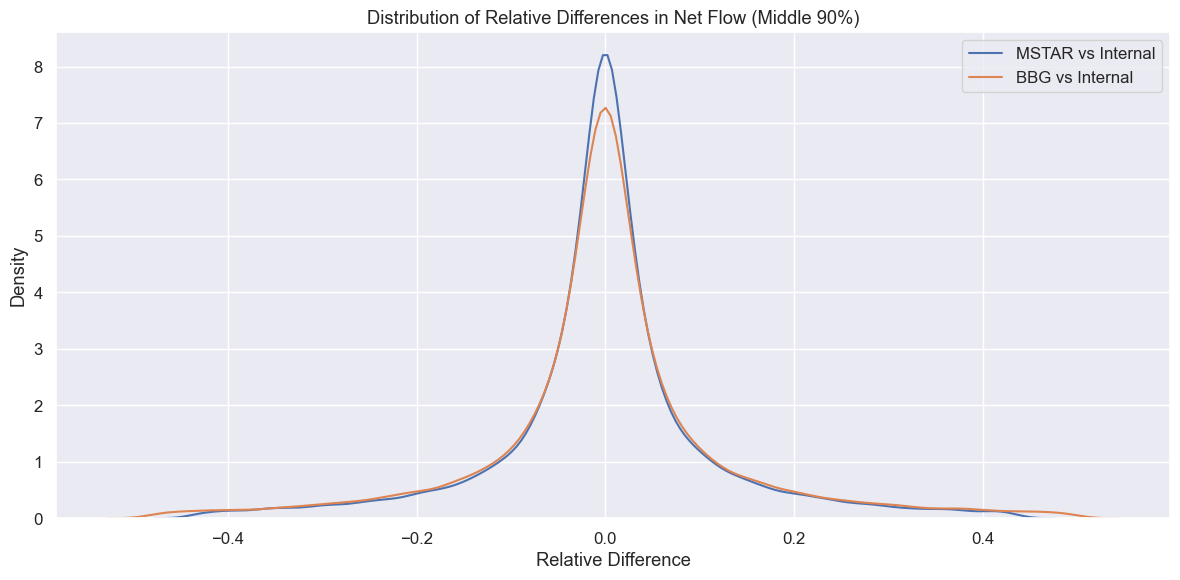

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. KDE plots for relative differences
plt.figure(figsize=(12, 6))
for source in ["mstar", "bbg"]:
    rel_diff_col = f"net_flow_rel_diff_{source}"
    filtered_data = merged_df[(merged_df[rel_diff_col] >= merged_df[rel_diff_col].quantile(0.05)) & 
                              (merged_df[rel_diff_col] <= merged_df[rel_diff_col].quantile(0.95))]
    sns.kdeplot(
        data=filtered_data,
        x=rel_diff_col,
        label=f"{source.upper()} vs Internal"
    )
plt.title("Distribution of Relative Differences in Net Flow (Middle 90%)")
plt.xlabel("Relative Difference")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

## Bar plot of mean relative differences

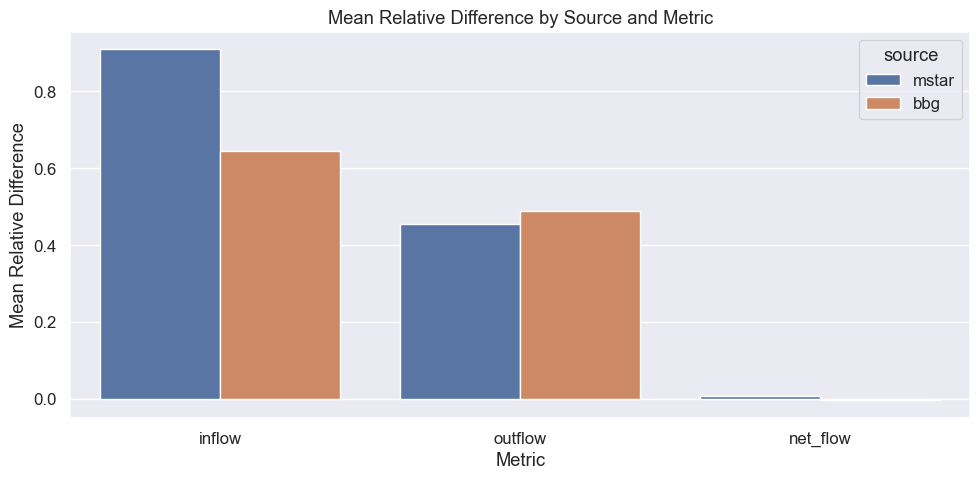

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(
    data=discrepancy_summary,
    x="metric",
    y="rel_mean",
    hue="source"
)
plt.title("Mean Relative Difference by Source and Metric")
plt.ylabel("Mean Relative Difference")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

## Box Plot of Relative Differences

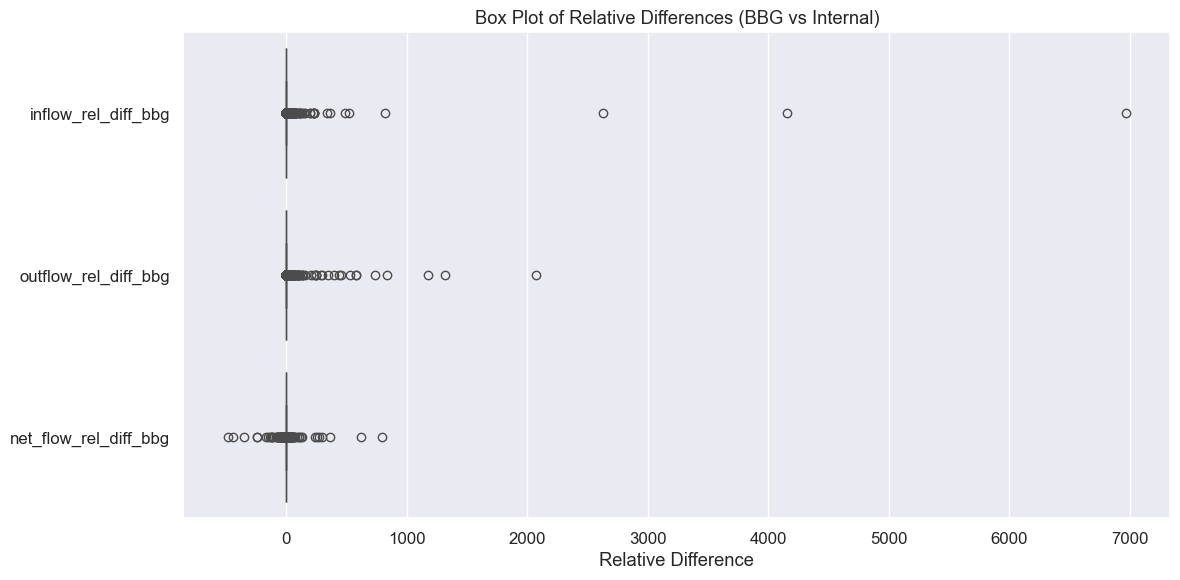

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_df.filter(like="rel_diff_bbg"),
    orient="h"
)
plt.title("Box Plot of Relative Differences (BBG vs Internal)")
plt.xlabel("Relative Difference")
plt.tight_layout()
plt.show()

## QQ Plot

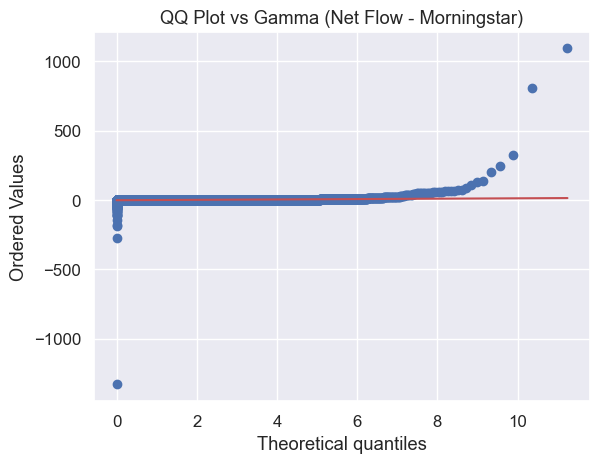

In [12]:
from scipy.stats import probplot
import matplotlib.pyplot as plt

plt.figure()
# Provide shape parameters for the gamma distribution using `sparams`
probplot(merged_df["net_flow_rel_diff_mstar"].dropna(), dist="gamma", sparams=(1,), plot=plt)
plt.title("QQ Plot vs Gamma (Net Flow - Morningstar)")
plt.show()


## ECDF of Relative Differences

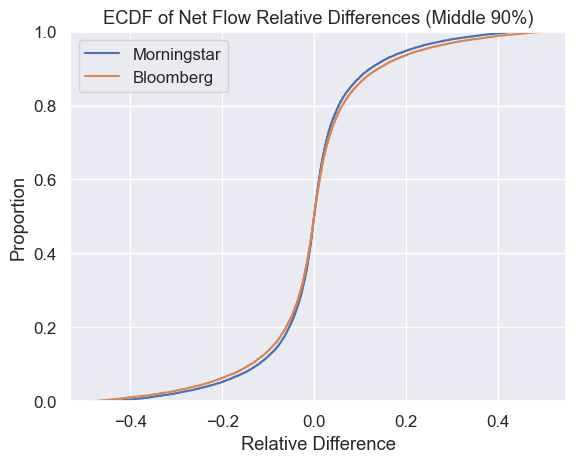

In [13]:
# Filter data to focus on the middle 90%
filtered_mstar = merged_df[(merged_df["net_flow_rel_diff_mstar"] >= merged_df["net_flow_rel_diff_mstar"].quantile(0.05)) & 
                           (merged_df["net_flow_rel_diff_mstar"] <= merged_df["net_flow_rel_diff_mstar"].quantile(0.95))]
filtered_bbg = merged_df[(merged_df["net_flow_rel_diff_bbg"] >= merged_df["net_flow_rel_diff_bbg"].quantile(0.05)) & 
                         (merged_df["net_flow_rel_diff_bbg"] <= merged_df["net_flow_rel_diff_bbg"].quantile(0.95))]

# Plot ECDF for the middle 90%
sns.ecdfplot(data=filtered_mstar, x="net_flow_rel_diff_mstar", label="Morningstar")
sns.ecdfplot(data=filtered_bbg, x="net_flow_rel_diff_bbg", label="Bloomberg")
plt.title("ECDF of Net Flow Relative Differences (Middle 90%)")
plt.xlabel("Relative Difference")
plt.legend()


## Heatmap of Mean Discrepancy by Ticker/Provider

Text(0.5, 1.0, 'Avg Net Flow Discrepancy (Morningstar) by Asset/Provider')

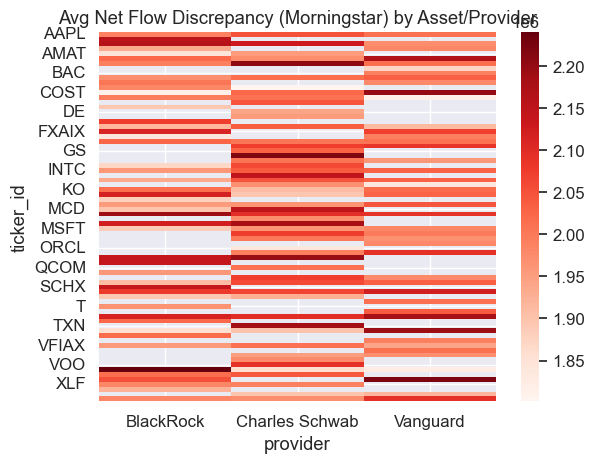

In [14]:
pivot = merged_df.groupby(["ticker_id", "provider"])["net_flow_abs_diff_mstar"].mean().unstack()
sns.heatmap(pivot, cmap="Reds", annot=False)
plt.title("Avg Net Flow Discrepancy (Morningstar) by Asset/Provider")


# Save Merged Data

In [15]:
merged_path = "../data/merged_flow_comparison.csv"
merged_df.to_csv(merged_path, index=False)

merged_path

'../data/merged_flow_comparison.csv'